In [1]:
import h5py
import numpy as np
import os
import matplotlib.pyplot as plt
import os
import tensorflow as tf

2025-08-01 07:56:27.988738: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754060188.002854 1614470 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754060188.007158 1614470 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754060188.019447 1614470 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754060188.019459 1614470 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754060188.019461 1614470 computation_placer.cc:177] computation placer alr

In [2]:
# minorized reference
with h5py.File('/global/u2/k/kberard/SCGSR/Research/Diamond/Data/density_tot_ref.h5', 'r') as file:
    #print("Keys: %s" % file.keys())
    ref_d = file['density'][:]
#print(ref_d)
print(ref_d.shape)




(64, 64, 64)


In [3]:
####################################################################################################################################################
def stochastic_density(d,N):
    # poisson model
    #  accurate and fast for all values of N
    # N  = number of MC samples
    assert isinstance(d,np.ndarray)
    assert isinstance(N,(int,float,np.int64,np.float64))
    assert N>0
    ds = np.random.poisson(N*d)/N
    ds*= d.sum()/ds.sum()
    return ds
#end def stochastic_density

####################################################################################################################################################

In [4]:
def generate_single_2d_density(ref_d, noise_level):
    noisy_3d = stochastic_density(ref_d, noise_level)  # shape: (64, 64, 64)
    return noisy_3d

# Noise levels to randomly draw from
noise_levels = [10000 * (j + 1) for j in range(5)]  # [10000, 20000, ..., 50000]

# Sizes
num_train = 5000
num_val = 1000
num_test = 500

# Generate train set with mixed noise levels
x_train = np.zeros((num_train, 64, 64,64))
for i in range(num_train):
    noise_level = np.random.choice(noise_levels)
    x_train[i] = generate_single_2d_density(ref_d, noise_level)

# Generate val set with mixed noise levels
x_val = np.zeros((num_val, 64, 64,64))
for i in range(num_val):
    noise_level = np.random.choice(noise_levels)
    x_val[i] = generate_single_2d_density(ref_d, noise_level)



print("Train, val, generated")


Train, val, generated


In [5]:
# Generate test set with fixed noise level
x_test = np.zeros((num_test, 64, 64, 64))
for i in range(num_test):
    x_test[i] = generate_single_2d_density(ref_d, 100000)
print("test generated")

test generated


In [6]:
y_test_3d = np.zeros((x_test.shape[0],64,64,64))
y_train_3d = np.zeros((x_train.shape[0],64,64,64))
y_val_3d = np.zeros((x_val.shape[0],64,64,64))
for i in range (y_test_3d.shape[0]):
    y_test_3d[i]=stochastic_density(ref_d,1000000)
y_test = y_test_3d
for i in range (y_train_3d.shape[0]):
    y_train_3d[i]=stochastic_density(ref_d,1000000)
y_train = y_train_3d

for i in range (y_val_3d.shape[0]):
    y_val_3d[i]=stochastic_density(ref_d,1000000)
y_val = y_val_3d
print("here")

here


In [25]:
#Try learning rate scheduler
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers
import matplotlib.pyplot as plt



@tf.keras.utils.register_keras_serializable()
class RenormalizeToEight(tf.keras.layers.Layer):
    def call(self, x):
        total = tf.reduce_sum(x, axis=[1, 2, 3, 4], keepdims=True)
        return x / (total + 1e-8) * 8.0

@tf.keras.utils.register_keras_serializable()
def jensen_shannon_divergence_loss(y_true, y_pred):
    y_t = tf.cast(y_true, tf.float32)
    y_p = tf.cast(y_pred, tf.float32)

    y_t = tf.reshape(y_t, [tf.shape(y_t)[0], -1])
    y_p = tf.reshape(y_p, [tf.shape(y_p)[0], -1])

    y_t /= tf.reduce_sum(y_t, axis=1, keepdims=True) + 1e-8
    y_p /= tf.reduce_sum(y_p, axis=1, keepdims=True) + 1e-8

    m = 0.5 * (y_t + y_p)
    kl_true = tf.reduce_sum(y_t * tf.math.log((y_t + 1e-8) / (m + 1e-8)), axis=1)
    kl_pred = tf.reduce_sum(y_p * tf.math.log((y_p + 1e-8) / (m + 1e-8)), axis=1)
    return tf.reduce_mean(0.5 * (kl_true + kl_pred))


def create_simple_3d_cae(input_shape=(64,64,64,1), dropout_rate=0.2, l2_strength=1e-4):
    reg = regularizers.l2(l2_strength)
    input_layer = layers.Input(shape=input_shape)

    x = layers.Conv3D(128, (3, 3, 3), activation='relu', padding='same')(input_layer)
    x = layers.MaxPooling3D((2, 2, 2))(x)
    x = layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling3D((2, 2, 2))(x)
    x = layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling3D((2, 2, 2))(x)
    x = layers.Conv3D(16, (3, 3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling3D((2, 2, 2))(x)

    # Bottleneck
    x = layers.Conv3D(16, (3, 3, 3), activation='relu', padding='same')(x)

    # Decoder
    x = layers.UpSampling3D((2, 2, 2))(x)
    x = layers.Conv3D(16, (3, 3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling3D((2, 2, 2))(x)
    x = layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling3D((2, 2, 2))(x)
    x = layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling3D((2, 2, 2))(x)
    x = layers.Conv3D(128, (3, 3, 3), activation='relu', padding='same')(x)
    x = layers.Conv3D(1, (3, 3, 3), activation='relu', padding='same')(x)

    # Normalize with custom layer
    output_layer = RenormalizeToEight()(x)

    return models.Model(inputs=input_layer, outputs=output_layer)



# --- Training Pipeline ---
if __name__ == '__main__':
    # Assume x_train_3d, y_train_3d, etc. are already loaded
    # Add channel dim: (64,64,64) → (64,64,64,1)


    # Build and compile model
    input_shape = (64, 64, 64, 1)
    cae = create_simple_3d_cae(input_shape)
    cae.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=jensen_shannon_divergence_loss)

    # Callbacks
    early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    lr_scheduler = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-6
)
    callbacks_list = [early_stop, lr_scheduler]

    # Train
    cae.fit(x_train, y_train,
            validation_data=(x_val, y_val),
            epochs=5,
            batch_size=4,
            callbacks=callbacks_list,
            verbose=1)



Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 70s 53ms/step - loss: 0.0258 - val_loss: 0.0045 - learning_rate: 1.0000e-04
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 64s 51ms/step - loss: 0.0044 - val_loss: 0.0043 - learning_rate: 1.0000e-04
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 64s 51ms/step - loss: 0.0043 - val_loss: 0.0043 - learning_rate: 1.0000e-04
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 64s 51ms/step - loss: 0.0043 - val_loss: 0.0043 - learning_rate: 1.0000e-04
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 64s 51ms/step - loss: 0.0043 - val_loss: 0.0043 - learning_rate: 1.0000e-04


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
(64, 64, 64)
(64, 64, 64)


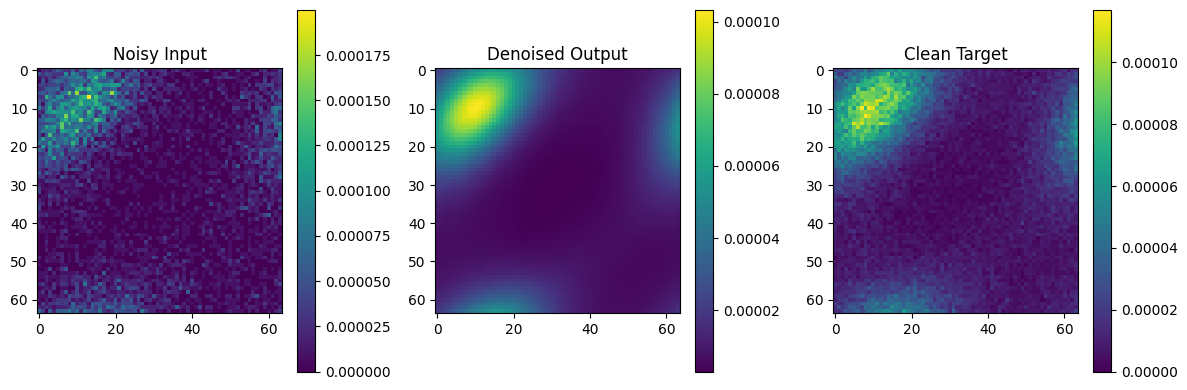

In [26]:
# Predict one test volume
i = 0
denoised = cae.predict(x_test[i:i+1])[0, ..., 0]
print(denoised.shape)
noisy_input = x_test[0]
true_clean = y_test[0]
print(noisy_input.shape)

# Plot mid-slice
z_mid = 64 // 2
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(noisy_input[:, :, z_mid], cmap='viridis')
plt.title("Noisy Input")
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(denoised[:, :, z_mid], cmap='viridis')
plt.title("Denoised Output")
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(true_clean[:, :, z_mid], cmap='viridis')
plt.title("Clean Target")
plt.colorbar()

plt.tight_layout()
plt.show()


(64, 64, 64)
(1, 64, 64, 64)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
(64, 64, 64)
(64, 64, 64)
(64, 64, 64)


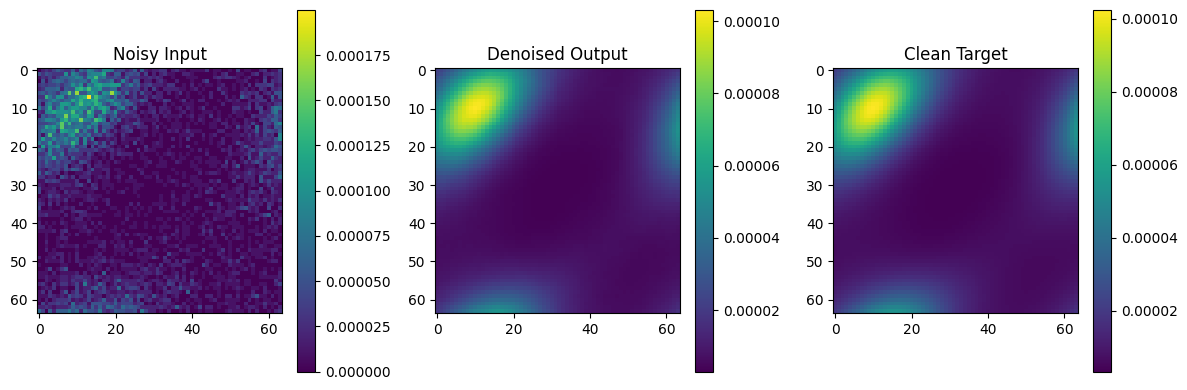

In [27]:
#### test file #######
with h5py.File('/pscratch/sd/k/kberard/SCGSR/Data/diamond_1x1x1_bfd/density_data/vmc_J2/density_tot_vmc_mean_0000655360.h5', 'r') as file:
    #print("Keys: %s" % file.keys())
    test_d = file['density'][:]

    # Predict one test volume
i = 0
print(test_d.shape)
print(x_test[i:i+1].shape)
denoised = cae.predict(np.array(test_d)[np.newaxis, ...])[0, ..., 0]
print(denoised.shape)
print(denoised.shape)
noisy_input = x_test[0]
true_clean = ref_d
print(noisy_input.shape)

# Plot mid-slice
z_mid = 64 // 2
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(noisy_input[:, :, z_mid], cmap='viridis')
plt.title("Noisy Input")
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(denoised[:, :, z_mid], cmap='viridis')
plt.title("Denoised Output")
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(true_clean[:, :, z_mid], cmap='viridis')
plt.title("Clean Target")
plt.colorbar()

plt.tight_layout()
plt.show()


In [28]:
print(x_test.shape,"Shape of test set")
# must beat the model predicting the average
test_avg = np.mean(x_test,axis=0)
print(test_avg.shape, "Shape of average of test set")
print(ref_d.shape,"reference shape")
print("2 norm difference")
print("Mean vs DFT 2 norm diff")
print(np.linalg.norm(test_avg[:,:,:]-ref_d))

print("prediction of one test sample vs DFT")
print(x_test[0:0+1].shape,"test_shape")
print(cae.predict(x_test[0:0+1])[0,:,:,:,0].shape,ref_d.shape)
print(np.linalg.norm(cae.predict(x_test[0:0+1])[0,:,:,:,0]-ref_d))
print()
print()
print("divergence difference")
print(test_avg.shape)
mean_pred = cae.predict(test_avg.reshape(1,64,64,64))[0,:,:,:,0]                 
print("JSD (bar{x_test},y_dft):", jensen_shannon_divergence_loss(test_avg, ref_d.copy()))
print("JSD (DAE(bar{x}),y_dft):", jensen_shannon_divergence_loss(np.squeeze(mean_pred), ref_d.copy()))
print("JSD (DAE(_i}),y_dft):", jensen_shannon_divergence_loss(cae.predict(x_test[0:0+1])[0,:,:,:,0], ref_d.copy()))


print("Working slightly better!!!!!!!!")

(500, 64, 64, 64) Shape of test set
(64, 64, 64) Shape of average of test set
(64, 64, 64) reference shape
2 norm difference
Mean vs DFT 2 norm diff
0.0004009081977597181
prediction of one test sample vs DFT
(1, 64, 64, 64) test_shape
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
(64, 64, 64) (64, 64, 64)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
0.0003034273685241429


divergence difference
(64, 64, 64)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
JSD (bar{x_test},y_dft): tf.Tensor(9.763439e-05, shape=(), dtype=float32)
JSD (DAE(bar{x}),y_dft): tf.Tensor(4.628927e-05, shape=(), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
JSD (DAE(_i}),y_dft): tf.Tensor(4.870798e-05, shape=(), dtype=float32)
Working slightly better!!!!!!!!


In [29]:
cae.save("CAE_3D.keras")  # This will store everything, including architecture, weights, loss, etc.
